In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob as gb
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet121,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, GlobalAveragePooling2D , Flatten,BatchNormalization
from tensorflow.keras.metrics import AUC, Recall, Precision, SpecificityAtSensitivity, SensitivityAtSpecificity, FalseNegatives, FalsePositives, TrueNegatives, TruePositives,F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path='/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/'

In [3]:
for folder in  os.listdir(path +'/train') : 
    files = gb.glob(pathname= str( path +'/train/' + folder + '/*.jpeg'))
    print(f'For train data , found {len(files)} in folder {folder}')

For train data , found 3883 in folder PNEUMONIA
For train data , found 1349 in folder NORMAL


In [4]:
for folder in  os.listdir(path +'/test') : 
    files = gb.glob(pathname= str( path +'/test/' + folder + '/*.jpeg'))
    print(f'For train data , found {len(files)} in folder {folder}')

For train data , found 390 in folder PNEUMONIA
For train data , found 234 in folder NORMAL


In [5]:
#most repeated size in train file
size=[]
for i in os.listdir(path+'train'):
    files=gb.glob(pathname=str(path+'train/'+i+'/*.jpeg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()
###############################################

(648, 1072, 3)     7
(728, 1080, 3)     6
(872, 1216, 3)     5
(664, 1152, 3)     5
(592, 992, 3)      5
                  ..
(896, 1424, 3)     1
(484, 843, 3)      1
(696, 1168, 3)     1
(440, 832, 3)      1
(1272, 1592, 3)    1
Name: count, Length: 4376, dtype: int64

In [6]:
#most repeated size in train file
size=[]
for i in os.listdir(path+'test'):
    files=gb.glob(pathname=str(path+'test//'+i+'/*.jpeg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()
###############################################

(736, 1112, 3)     3
(1048, 1400, 3)    2
(832, 1152, 3)     2
(616, 1072, 3)     2
(952, 1304, 3)     2
                  ..
(656, 952, 3)      1
(717, 1010, 3)     1
(1152, 1344, 3)    1
(720, 1410, 3)     1
(1478, 1873, 3)    1
Name: count, Length: 598, dtype: int64

In [7]:
# Create a mapping dictionary for class labels
class_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}# Add more classes as needed
img_size=100

In [8]:
x_train = []  # To store resized images
y_train = []  # To store class labels
for folder in os.listdir(path + 'train'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'train/' + folder + '/*.jpeg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_train.append(resized_image)
        y_train.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_train.shape)
print(y_train.shape)

(5232, 100, 100, 3)
(5232,)


In [9]:
x_test = []  # To store resized images
y_test = []  # To store class labels
for folder in os.listdir(path + 'test'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'test//' + folder + '/*.jpeg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_test.append(resized_image)
        y_test.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_test.shape)

(624, 100, 100, 3)


In [10]:
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    img = x_train[i]

    # Append original image
    augmented_images.append(img)
    augmented_labels.append(y_train[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images.append(img_vertical_flip)
    augmented_labels.append(y_train[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images.append(img_horizontal_flip)
    augmented_labels.append(y_train[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images.append(img_mirror)
    augmented_labels.append(y_train[i])

# Convert the augmented images and labels to NumPy arrays
x_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Print the shapes to verify
print(x_train.shape)
print(y_train.shape)

(20928, 100, 100, 3)
(20928,)


In [11]:
# Applying data augmentation to x_test
augmented_images_test = []
augmented_labels_test = []

for i in range(len(x_test)):
    img = x_test[i]

    # Append original image
    augmented_images_test.append(img)
    augmented_labels_test.append(y_test[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images_test.append(img_vertical_flip)
    augmented_labels_test.append(y_test[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images_test.append(img_horizontal_flip)
    augmented_labels_test.append(y_test[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images_test.append(img_mirror)
    augmented_labels_test.append(y_test[i])

# Convert the augmented test images and labels to NumPy arrays
x_test = np.array(augmented_images_test)
y_test = np.array(augmented_labels_test)

# Print the shapes to verify
print(x_test.shape)
print(y_test.shape)

(2496, 100, 100, 3)
(2496,)


In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_valid.shape)
print(y_valid.shape)

(4186, 100, 100, 3)
(4186,)


In [13]:
x_train=x_train/255
x_test=x_test/255
x_valid=x_valid/255

In [14]:
# Create a VGG16 model with pre-trained weights on ImageNet
pretrained_model_vgg16 = VGG16(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_vgg16.layers:
    layer.trainable = False

# Create a Sequential model
vgg16_model = Sequential()

# Add the VGG16 pre-trained model to your Sequential model
vgg16_model.add(pretrained_model_vgg16)

# Flatten layer
vgg16_model.add(Flatten())

# Dense layers
vgg16_model.add(Dense(32, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("VGG16 Model Summary:")
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
VGG16 Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14731137 (56.19 MB)
Trainable params: 16449 (64.25 KB)
Non-trainable params: 14714688 (5

Epoch 1/100
1047/1047 [==============================] - 27s 19ms/step - loss: 0.3702 - accuracy: 0.8464 - auc: 0.9262 - recall: 0.8393 - precision: 0.9474 - specificity_at_sensitivity: 0.9845 - sensitivity_at_specificity: 0.9703 - false_negatives: 1994.0000 - false_positives: 578.0000 - true_negatives: 3755.0000 - true_positives: 10415.0000 - val_loss: 0.2151 - val_accuracy: 0.9185 - val_auc: 0.9675 - val_recall: 0.9328 - val_precision: 0.9570 - val_specificity_at_sensitivity: 0.9915 - val_sensitivity_at_specificity: 0.9930 - val_false_negatives: 210.0000 - val_false_positives: 131.0000 - val_true_negatives: 932.0000 - val_true_positives: 2913.0000
Epoch 2/100
1047/1047 [==============================] - 17s 16ms/step - loss: 0.2423 - accuracy: 0.9078 - auc: 0.9650 - recall: 0.9044 - precision: 0.9692 - specificity_at_sensitivity: 0.9945 - sensitivity_at_specificity: 0.9881 - false_negatives: 1186.0000 - false_positives: 357.0000 - true_negatives: 3976.0000 - true_positives: 11223.000

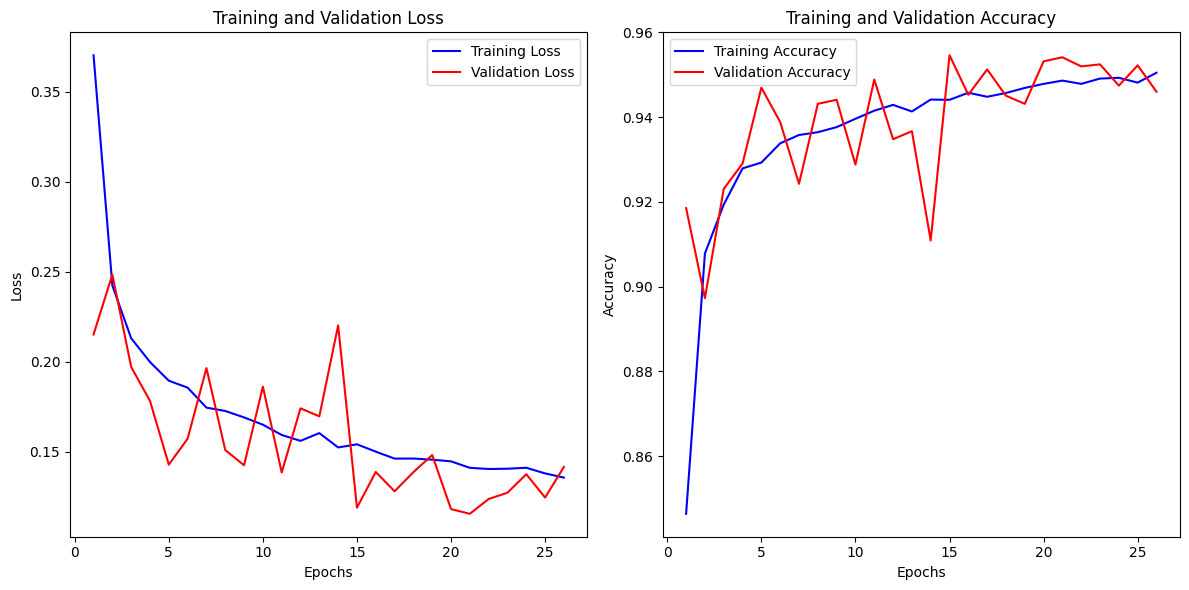

In [15]:
# Calculate class weights
y_vgg16= y_train
class_weights_vgg16 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_vgg16)

# Convert to dictionary
class_weight_dict_vgg16 = dict(enumerate(class_weights_vgg16))
#compile model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
vgg16_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_vgg16,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = vgg16_model.history.history['loss']
validation_loss = vgg16_model.history.history['val_loss']
training_accuracy = vgg16_model.history.history['accuracy']
validation_accuracy = vgg16_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
results_vgg16 = vgg16_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_vgg16[0])
print("Test Accuracy:", results_vgg16[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_vgg16 = vgg16_model.predict(x_test)

78/78 [==============================] - 2s 19ms/step - loss: 0.5084 - accuracy: 0.8333 - auc: 0.9140 - recall: 0.9609 - precision: 0.8085 - specificity_at_sensitivity: 0.9466 - sensitivity_at_specificity: 0.9846 - false_negatives: 61.0000 - false_positives: 355.0000 - true_negatives: 581.0000 - true_positives: 1499.0000
Test Loss: 0.5084041953086853
Test Accuracy: 0.8333333134651184
78/78 [==============================] - 1s 16ms/step


131/131 [==============================] - 3s 20ms/step


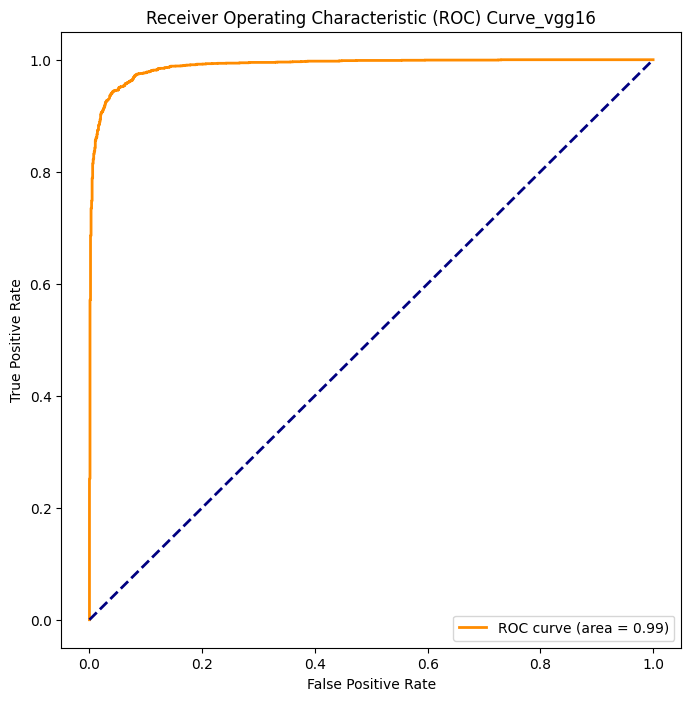

In [17]:
y_pred_vgg16 = vgg16_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_vgg16)

# Calculate the area under the curve (AUC)
roc_auc_vgg16 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_vgg16))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_vgg16')
plt.legend(loc='lower right')
plt.show()

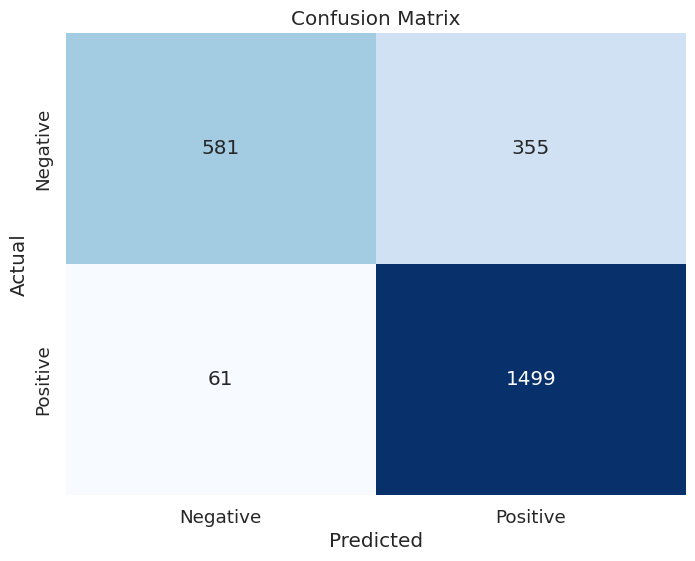

F1 Score: 0.8781487990626832
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.62      0.74       936
           1       0.81      0.96      0.88      1560

    accuracy                           0.83      2496
   macro avg       0.86      0.79      0.81      2496
weighted avg       0.84      0.83      0.82      2496



In [18]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_vgg16 = (predictions_vgg16 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_vgg16)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_vgg16 = f1_score(y_test, binary_predictions_vgg16)

# Print F1 score
print("F1 Score:", f1_vgg16)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_vgg16))

In [19]:
# Create a resnet50 model with pre-trained weights on ImageNet
pretrained_model_resnet50 = ResNet50(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

# Create a Sequential model
resnet50_model = Sequential()

# Add the resnet50 pre-trained model to your Sequential model
resnet50_model.add(pretrained_model_resnet50)

# Flatten layer
resnet50_model.add(Flatten())

# Dense layers
resnet50_model.add(Dense(32, activation='relu'))
resnet50_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("resnet50 Model Summary:")
resnet50_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
resnet50 Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23653313 (90.23 MB)
Trainable params: 65601 (256.25 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Epoch 1/100
1047/1047 [==============================] - 29s 23ms/step - loss: 0.4728 - accuracy: 0.7900 - auc_1: 0.8707 - recall_1: 0.7912 - precision_1: 0.9139 - specificity_at_sensitivity_1: 0.9550 - sensitivity_at_specificity_1: 0.9309 - false_negatives_1: 2591.0000 - false_positives_1: 925.0000 - true_negatives_1: 3408.0000 - true_positives_1: 9818.0000 - val_loss: 0.3107 - val_accuracy: 0.8691 - val_auc_1: 0.9283 - val_recall_1: 0.9084 - val_precision_1: 0.9155 - val_specificity_at_sensitivity_1: 0.9878 - val_sensitivity_at_specificity_1: 0.9590 - val_false_negatives_1: 286.0000 - val_false_positives_1: 262.0000 - val_true_negatives_1: 801.0000 - val_true_positives_1: 2837.0000
Epoch 2/100
1047/1047 [==============================] - 20s 19ms/step - loss: 0.3359 - accuracy: 0.8561 - auc_1: 0.9311 - recall_1: 0.8508 - precision_1: 0.9498 - specificity_at_sensitivity_1: 0.9898 - sensitivity_at_specificity_1: 0.9653 - false_negatives_1: 1852.0000 - false_positives_1: 558.0000 - true

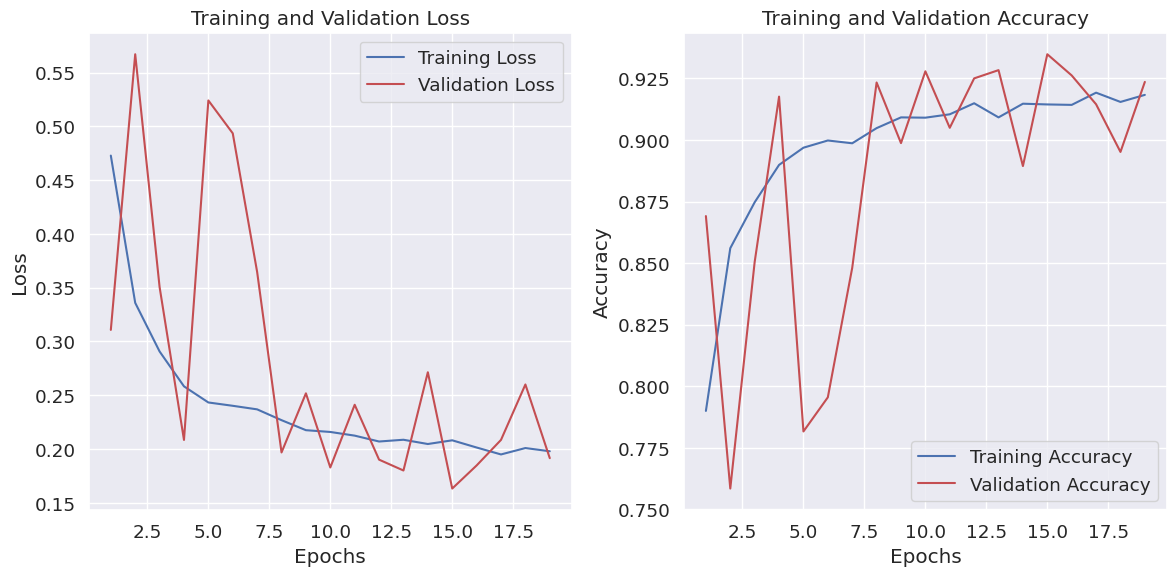

In [20]:
# Calculate class weights
y_resnet50= y_train
class_weights_resnet50 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_resnet50)

# Convert to dictionary
class_weight_dict_resnet50 = dict(enumerate(class_weights_resnet50))
#compile model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
resnet50_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_resnet50,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = resnet50_model.history.history['loss']
validation_loss = resnet50_model.history.history['val_loss']
training_accuracy = resnet50_model.history.history['accuracy']
validation_accuracy = resnet50_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
results_resnet50 = resnet50_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_resnet50[0])
print("Test Accuracy:", results_resnet50[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_resnet50 = resnet50_model.predict(x_test)

78/78 [==============================] - 2s 21ms/step - loss: 0.5091 - accuracy: 0.7877 - auc_1: 0.8921 - recall_1: 0.9442 - precision_1: 0.7688 - specificity_at_sensitivity_1: 0.9679 - sensitivity_at_specificity_1: 0.9513 - false_negatives_1: 87.0000 - false_positives_1: 443.0000 - true_negatives_1: 493.0000 - true_positives_1: 1473.0000
Test Loss: 0.5091420412063599
Test Accuracy: 0.7876602411270142
78/78 [==============================] - 2s 17ms/step


131/131 [==============================] - 4s 20ms/step


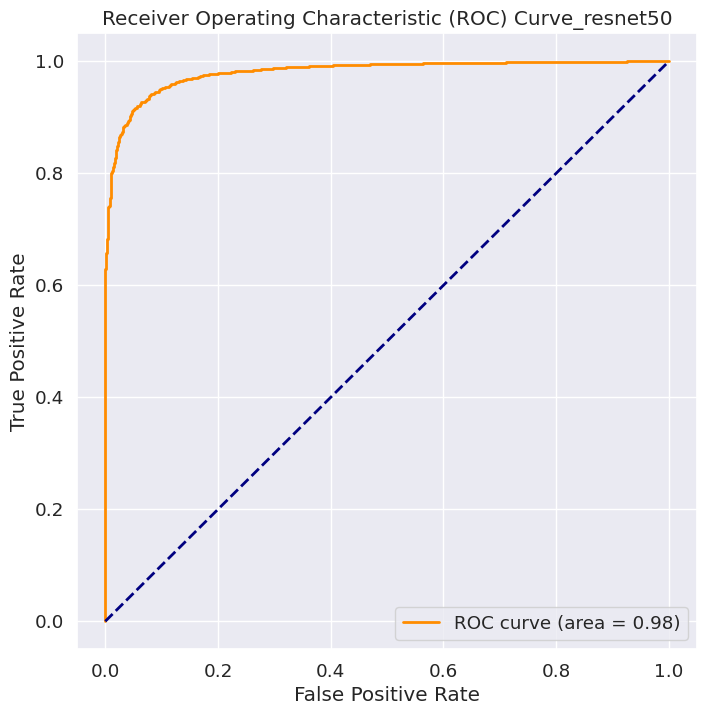

In [22]:
y_pred_resnet50 = resnet50_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_resnet50)

# Calculate the area under the curve (AUC)
roc_auc_resnet50 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_resnet50))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_resnet50')
plt.legend(loc='lower right')
plt.show()

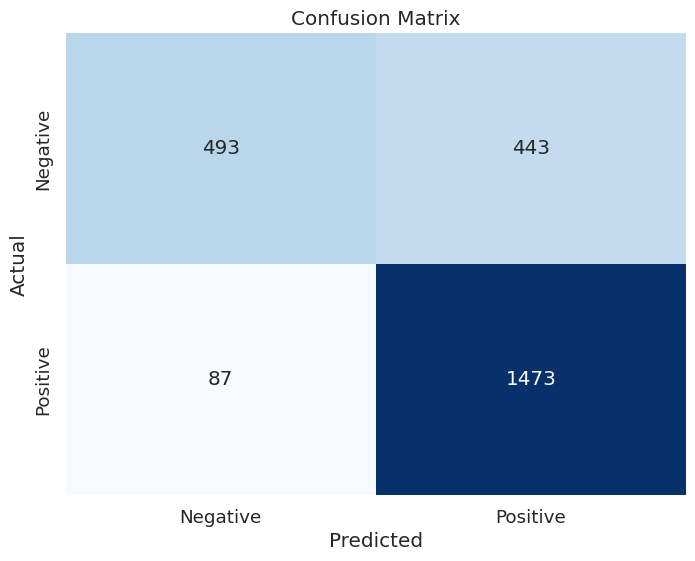

F1 Score: 0.8475258918296892
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.53      0.65       936
           1       0.77      0.94      0.85      1560

    accuracy                           0.79      2496
   macro avg       0.81      0.74      0.75      2496
weighted avg       0.80      0.79      0.77      2496



In [23]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_resnet50 = (predictions_resnet50 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_resnet50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_resnet50 = f1_score(y_test, binary_predictions_resnet50)

# Print F1 score
print("F1 Score:", f1_resnet50)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_resnet50))

In [24]:
# Create a DenseNet121 model with pre-trained weights on ImageNet
pretrained_model_DenseNet121 = DenseNet121(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_DenseNet121.layers:
    layer.trainable = False

# Create a Sequential model
DenseNet121_model = Sequential()

# Add the DenseNet121 pre-trained model to your Sequential model
DenseNet121_model.add(pretrained_model_DenseNet121)

# Flatten layer
DenseNet121_model.add(Flatten())

# Dense layers
DenseNet121_model.add(Dense(16, activation='relu'))
DenseNet121_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("DenseNet121 Model Summary:")
DenseNet121_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
DenseNet121 Model Summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                16400     
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7053921 (26.91 MB)
Trainable params: 16417 (64.13 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


Epoch 1/100
1047/1047 [==============================] - 37s 27ms/step - loss: 0.1954 - accuracy: 0.9194 - auc_2: 0.9767 - recall_2: 0.9174 - precision_2: 0.9722 - specificity_at_sensitivity_2: 0.9986 - sensitivity_at_specificity_2: 0.9943 - false_negatives_2: 1025.0000 - false_positives_2: 325.0000 - true_negatives_2: 4008.0000 - true_positives_2: 11384.0000 - val_loss: 0.1525 - val_accuracy: 0.9381 - val_auc_2: 0.9877 - val_recall_2: 0.9331 - val_precision_2: 0.9831 - val_specificity_at_sensitivity_2: 1.0000 - val_sensitivity_at_specificity_2: 0.9984 - val_false_negatives_2: 209.0000 - val_false_positives_2: 50.0000 - val_true_negatives_2: 1013.0000 - val_true_positives_2: 2914.0000
Epoch 2/100
1047/1047 [==============================] - 22s 21ms/step - loss: 0.1282 - accuracy: 0.9489 - auc_2: 0.9892 - recall_2: 0.9466 - precision_2: 0.9838 - specificity_at_sensitivity_2: 0.9998 - sensitivity_at_specificity_2: 0.9972 - false_negatives_2: 663.0000 - false_positives_2: 193.0000 - true

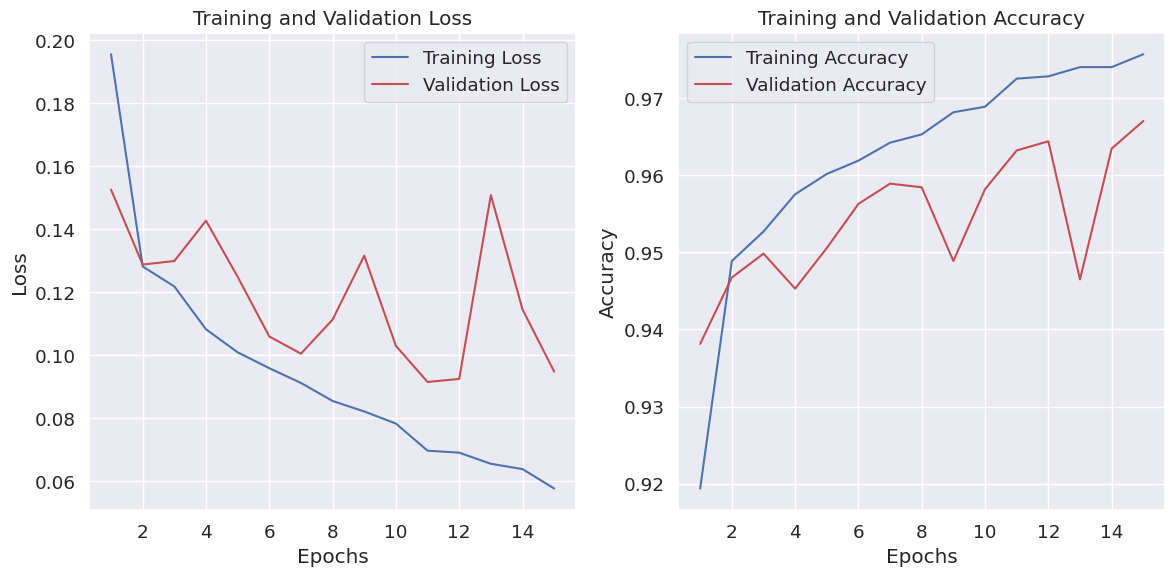

In [25]:
# Calculate class weights
y_DenseNet121= y_train
class_weights_DenseNet121 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_DenseNet121)

# Convert to dictionary
class_weight_dict_DenseNet121 = dict(enumerate(class_weights_DenseNet121))
#compile model
DenseNet121_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
DenseNet121_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_DenseNet121,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = DenseNet121_model.history.history['loss']
validation_loss = DenseNet121_model.history.history['val_loss']
training_accuracy = DenseNet121_model.history.history['accuracy']
validation_accuracy = DenseNet121_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
results_DenseNet121 = DenseNet121_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_DenseNet121[0])
print("Test Accuracy:", results_DenseNet121[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_DenseNet121 = DenseNet121_model.predict(x_test)

78/78 [==============================] - 3s 22ms/step - loss: 0.7600 - accuracy: 0.8377 - auc_2: 0.9046 - recall_2: 0.9763 - precision_2: 0.8054 - specificity_at_sensitivity_2: 0.8568 - sensitivity_at_specificity_2: 0.9885 - false_negatives_2: 37.0000 - false_positives_2: 368.0000 - true_negatives_2: 568.0000 - true_positives_2: 1523.0000
Test Loss: 0.7600106000900269
Test Accuracy: 0.8377403616905212
78/78 [==============================] - 4s 17ms/step


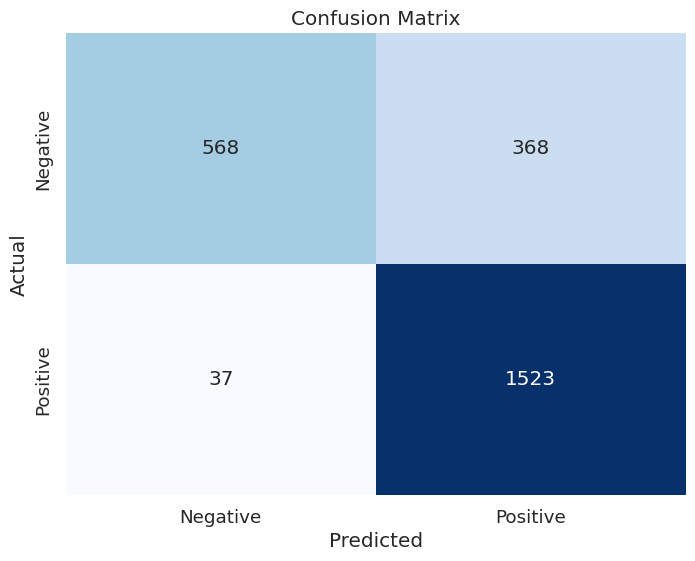

F1 Score: 0.8826427122573167
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       936
           1       0.81      0.98      0.88      1560

    accuracy                           0.84      2496
   macro avg       0.87      0.79      0.81      2496
weighted avg       0.86      0.84      0.83      2496



In [27]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_DenseNet121 = (predictions_DenseNet121 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_DenseNet121)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_DenseNet121 = f1_score(y_test, binary_predictions_DenseNet121)

# Print F1 score
print("F1 Score:", f1_DenseNet121)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_DenseNet121))

In [28]:
# Create a inceptionv3 model with pre-trained weights on ImageNet
pretrained_model_inceptionv3 = InceptionV3(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

# Create a Sequential model
inceptionv3_model = Sequential()

# Add the inceptionv3 pre-trained model to your Sequential model
inceptionv3_model.add(pretrained_model_inceptionv3)

# Flatten layer
inceptionv3_model.add(Flatten())

# Dense layers
inceptionv3_model.add(Dense(32, activation='relu'))
inceptionv3_model.add(Dropout(0.5))
inceptionv3_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("inceptionv3 Model Summary:")
inceptionv3_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
inceptionv3 Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21868385 (83.42 MB)
Trainable params: 65601 (256.25 KB)
Non-trainable params: 21

Epoch 1/100
1047/1047 [==============================] - 31s 24ms/step - loss: 0.3552 - accuracy: 0.8402 - auc_3: 0.9248 - recall_3: 0.8292 - precision_3: 0.9488 - specificity_at_sensitivity_3: 0.9778 - sensitivity_at_specificity_3: 0.9757 - false_negatives_3: 2120.0000 - false_positives_3: 555.0000 - true_negatives_3: 3778.0000 - true_positives_3: 10289.0000 - val_loss: 0.2092 - val_accuracy: 0.9152 - val_auc_3: 0.9680 - val_recall_3: 0.9337 - val_precision_3: 0.9517 - val_specificity_at_sensitivity_3: 0.9962 - val_sensitivity_at_specificity_3: 0.9936 - val_false_negatives_3: 207.0000 - val_false_positives_3: 148.0000 - val_true_negatives_3: 915.0000 - val_true_positives_3: 2916.0000
Epoch 2/100
1047/1047 [==============================] - 21s 20ms/step - loss: 0.2860 - accuracy: 0.8794 - auc_3: 0.9516 - recall_3: 0.8804 - precision_3: 0.9533 - specificity_at_sensitivity_3: 0.9905 - sensitivity_at_specificity_3: 0.9865 - false_negatives_3: 1484.0000 - false_positives_3: 535.0000 - tru

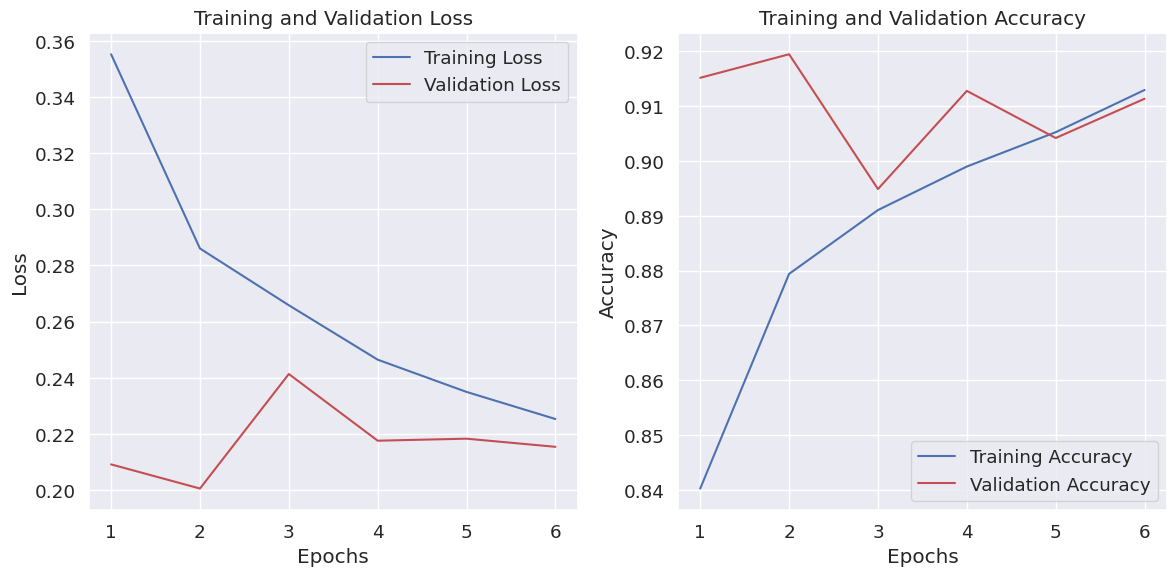

In [29]:
# Calculate class weights
y_inceptionv3= y_train
class_weights_inceptionv3 = compute_class_weight('balanced', classes=np.unique(y_train), y=y_inceptionv3)

# Convert to dictionary
class_weight_dict_inceptionv3 = dict(enumerate(class_weights_inceptionv3))
#compile model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
inceptionv3_model.fit(x_train,y_train, batch_size=16,epochs = 100, validation_data = (x_valid,y_valid),class_weight=class_weight_dict_inceptionv3,callbacks=[early_stopping])
# Accessing training and validation history
training_loss = inceptionv3_model.history.history['loss']
validation_loss = inceptionv3_model.history.history['val_loss']
training_accuracy = inceptionv3_model.history.history['accuracy']
validation_accuracy = inceptionv3_model.history.history['val_accuracy']

# Plotting the training and validation loss
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
results_inceptionv3 = inceptionv3_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_inceptionv3[0])
print("Test Accuracy:", results_inceptionv3[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_inceptionv3 = inceptionv3_model.predict(x_test)

78/78 [==============================] - 2s 19ms/step - loss: 0.5009 - accuracy: 0.8213 - auc_3: 0.8975 - recall_3: 0.9365 - precision_3: 0.8081 - specificity_at_sensitivity_3: 0.9605 - sensitivity_at_specificity_3: 0.9660 - false_negatives_3: 99.0000 - false_positives_3: 347.0000 - true_negatives_3: 589.0000 - true_positives_3: 1461.0000
Test Loss: 0.5009273290634155
Test Accuracy: 0.8213140964508057
78/78 [==============================] - 3s 15ms/step


131/131 [==============================] - 4s 20ms/step


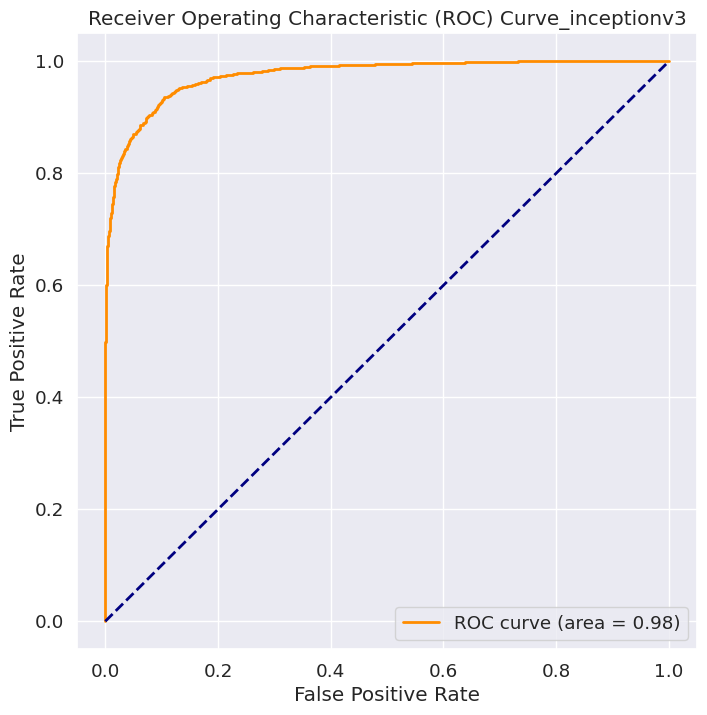

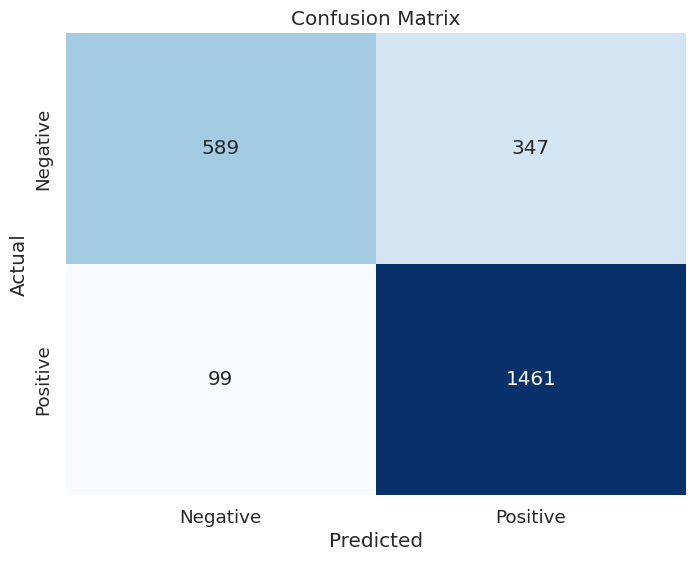

F1 Score: 0.8675771971496437
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       936
           1       0.81      0.94      0.87      1560

    accuracy                           0.82      2496
   macro avg       0.83      0.78      0.80      2496
weighted avg       0.83      0.82      0.81      2496



In [31]:
y_pred_inceptionv3 = inceptionv3_model.predict(x_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred_inceptionv3)

# Calculate the area under the curve (AUC)
roc_auc_inceptionv3 = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_inceptionv3))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve_inceptionv3')
plt.legend(loc='lower right')
plt.show()
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_inceptionv3 = (predictions_inceptionv3 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_inceptionv3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_inceptionv3 = f1_score(y_test, binary_predictions_inceptionv3)

# Print F1 score
print("F1 Score:", f1_inceptionv3)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_inceptionv3))